<a href="https://colab.research.google.com/github/AndryADSM/Asset-Analyzer/blob/main/asset_analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📈 Asset Analyzer

## Project in progress!

My Website: https://aadsm2355.wixsite.com/andryadsm

# Set up

In [1]:
# !pip install yfinance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

```
(
    tickers:     Unknown,
    period:      str            = "max",
    interval:    str            = "1d",
    start:       Unknown | None = None,
    end:         Unknown | None = None,
    group_by:    str            = 'column',
    prepost:     bool           = False,
    auto_adjust: bool           = False,
    repair:      bool           = False,
    keepna:      bool           = False,
    actions:     bool           = False,
    threads:     bool           = True,
    ignore_tz:   Unknown | None = None,
    proxy:       Unknown | None = None,
    rounding:    bool           = False,
    show_errors: Unknown | None = None,
    timeout:     int            = 10,
    session:     Unknown | None = None
    back_adjust: bool           = False,
    progress:    bool           = True,
 ) -> Unknown

Download yahoo tickers
:Parameters:
    tickers:     str, list
        List of tickers to download
    period:      str
        Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        Either Use period parameter or use start and end
    interval:    str
        Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        Intraday data cannot extend last 60 days
    start:       str
        Download start date string (YYYY-MM-DD) or _datetime, inclusive.
        Default is 99 years ago
        E.g. for start="2020-01-01", the first data point will be on "2020-01-01"
    end:         str
        Download end date string (YYYY-MM-DD) or _datetime, exclusive.
        Default is now
        E.g. for end="2023-01-01", the last data point will be on "2022-12-31"
    group_by:    str
        Group by 'ticker' or 'column' (default)
    prepost:     bool
        Include Pre and Post market data in results?
        Default is False
    auto_adjust: bool
        Adjust all OHLC automatically? Default is False
    repair:      bool
        Detect currency unit 100x mixups and attempt repair
        Default is False
    keepna:      bool
        Keep NaN rows returned by Yahoo?
        Default is False
    actions:     bool
        Download dividend + stock splits data. Default is False
    threads:     bool / int
        How many threads to use for mass downloading. Default is True
    ignore_tz:   bool
        When combining from different timezones, ignore that part of datetime.
        Default depends on interval. Intraday = False. Day+ = True.
    proxy:       str
        Optional. Proxy server URL scheme. Default is None
    rounding:    bool
        Optional. Round values to 2 decimal places?
    show_errors: bool
        Optional. Doesn't print errors if False
        DEPRECATED, will be removed in future version
    timeout:     None or float
        If not None stops waiting for a response after given number of
        seconds. (Can also be a fraction of a second e.g. 0.01)
    session:     None or Session
        Optional. Pass your own session object to be used for all requests
```



In [2]:
def download_data(
    tickers:     list[str],
    start:       str  = '1900-01-01',
    end:         str  = '2100-01-01',
    interval:    str  = '1d',
    *,
    actions:     bool = False,
    auto_adjust: bool = False
) -> pd.DataFrame:

    """
    Downloads data from Yahoo Finance, gets the weekday number and name and creates columns of normalized prices
    ### Params
    tickers:     str, list
        List of tickers to download
    interval:    str
        Valid intervals: '1m', '2m', '5m', '15m', '30m', '60m', '90m', '1h', '1d', '5d', '1wk', '1mo' or '3mo'
        intraday data cannot extend last 60 days
        except '60m' or '1h' which can be up to 730 days (1.5 years)
        and '1m' which only can be up to 7 days (1 week)

    #### Returns DataFrame
    """

    data = yf.download(tickers, start=start, end=end, group_by='ticker', interval=interval, actions=actions, auto_adjust=auto_adjust)

    if len(tickers) == 1:
        data.columns = pd.MultiIndex.from_product([tickers, data.columns], names=['Ticker', 'Price'])
    return data[tickers]

tickers = ['SPY', 'AAPL']#, 'TSLA', 'KO']#, 'DIS', 'BAC', 'XOM', 'GLD', 'CMG', 'USO', 'META']
# ['SPY', 'AAPL', 'META', 'GOOGL', 'MSFT', 'NFLX', 'DIS', 'AMZN', 'TSLA', 'MRNA', 'CMG', 'AMD', 'NVDA', 'BAC', 'XOM', 'CVX', 'USO', 'SLV', 'GLD']
data = download_data(tickers, '2023-01-01', '2024-01-01', '1h')
# data

[*********************100%%**********************]  2 of 2 completed


# Get dataframes

In [3]:
def pct_returns_daily(
    data:      pd.DataFrame,
    *,
    round_val: int  = 6,
    as_pct:    bool = True
) -> pd.DataFrame:

    """
    Percentage return in different time frames

    ### Params
    data: pd.DataFrame
        takes data of interval '1d' and no modifications
    as_pct: bool=True
        if True values are expressed as percentages (e.g. 1.23 (%)), if False as decimals (e.g. 0.0123)
    """

    returns = pd.DataFrame(index=data.index, columns=pd.MultiIndex.from_product([[], []], names=['Ticker', 'TimeFrame']))

    for tk in data.columns.get_level_values(0).unique():
        # Intraday, open to close
        returns[tk, 'Intraday'] = (data[tk, 'Close'] - data[tk, 'Open']) / data[tk, 'Open'] * 100
        # Overnight, close of previous day and todays open
        returns[tk, 'Overnight'] = (data[tk, 'Open'] - data[tk, 'Close'].shift(1)) / data[tk, 'Close'].shift(1) * 100
        # Daily, close to close
        returns[tk, 'Daily'] = data[tk, 'Close'].pct_change() * 100
        # Weekly and 2-3-4-week, 5 days apart per week close to close
        for week, shift in [(i, i * 5) for i in range(1, 5)]:
            returns[tk, f'{week}week'] = (data[tk, 'Close'] - data[tk, 'Close'].shift(shift)) / data[tk, 'Close'].shift(shift) * 100

    returns = returns.round(round_val)

    # Turn percentage into decimal
    if as_pct == False:
        returns /= 100

    return returns

returns = pct_returns_daily(data)
returns.head(10)

Ticker                          SPY                                            \
TimeFrame                  Intraday Overnight     Daily     1week 2week 3week   
Datetime                                                                        
2023-01-03 09:30:00-05:00 -0.892367       NaN       NaN       NaN   NaN   NaN   
2023-01-03 10:30:00-05:00 -0.034197 -0.204756 -0.238884       NaN   NaN   NaN   
2023-01-03 11:30:00-05:00 -0.288972  0.002160 -0.286818       NaN   NaN   NaN   
2023-01-03 12:30:00-05:00  0.146450  0.006596  0.153055       NaN   NaN   NaN   
2023-01-03 13:30:00-05:00 -0.139650  0.000000 -0.139650       NaN   NaN   NaN   
2023-01-03 14:30:00-05:00  0.358835  0.002641  0.361486 -0.152259   NaN   NaN   
2023-01-03 15:30:00-05:00  0.120933  0.002632  0.123567  0.210506   NaN   NaN   
2023-01-04 09:30:00-05:00 -0.399290  0.617075  0.215321  0.715151   NaN   NaN   
2023-01-04 10:30:00-05:00  0.505961  0.000000  0.505961  1.070037   NaN   NaN   
2023-01-04 11:30:00-05:00  0.415798  0.004957  0.420775  1.637251   NaN   NaN   

Ticker                               AAPL                                      \
TimeFrame                 4week  Intraday Overnight     Daily     1week 2week   
Datetime                                                                        
2023-01-03 09:30:00-05:00   NaN -3.321265       NaN       NaN       NaN   NaN   
2023-01-03 10:30:00-05:00   NaN -0.091661  0.000000 -0.091661       NaN   NaN   
2023-01-03 11:30:00-05:00   NaN -0.550612  0.004145 -0.546490       NaN   NaN   
2023-01-03 12:30:00-05:00   NaN -0.008103  0.000000 -0.008103       NaN   NaN   
2023-01-03 13:30:00-05:00   NaN -0.080131  0.016042 -0.064102       NaN   NaN   
2023-01-03 14:30:00-05:00   NaN  0.033714  0.006425  0.040141 -0.669533   NaN   
2023-01-03 15:30:00-05:00   NaN  0.337002  0.008020  0.345049 -0.235349   NaN   
2023-01-04 09:30:00-05:00   NaN -0.702735  1.471408  0.758333  1.073556   NaN   
2023-01-04 10:30:00-05:00   NaN  1.103262 -0.006588  1.096601  2.190210   NaN   
2023-01-04 11:30:00-05:00   NaN  0.529871  0.007852  0.537765  2.805654   NaN   

Ticker                                 
TimeFrame                 3week 4week  
Datetime                               
2023-01-03 09:30:00-05:00   NaN   NaN  
2023-01-03 10:30:00-05:00   NaN   NaN  
2023-01-03 11:30:00-05:00   NaN   NaN  
2023-01-03 12:30:00-05:00   NaN   NaN  
2023-01-03 13:30:00-05:00   NaN   NaN  
2023-01-03 14:30:00-05:00   NaN   NaN  
2023-01-03 15:30:00-05:00   NaN   NaN  
2023-01-04 09:30:00-05:00   NaN   NaN  
2023-01-04 10:30:00-05:00   NaN   NaN  
2023-01-04 11:30:00-05:00   NaN   NaN

In [4]:
def pct_returns(
    data: pd.DataFrame,
    values = {'Daily': ('Close', 'Close', 1)},
    *,
    round_val: int  = 6,
    as_pct:    bool = True
) -> pd.DataFrame:

    """
    Percentage return in different time frames

    ### Params
    - data: pd.DataFrame
        takes unmodified data
    - values: {str: (str, str, int)} = {'Daily': ('Close', 'Close', 1)}
        Notation goes like this: {'Name_of_return': ('After_price', 'Before_price', shift_of_before_price)}
        guide yourself with the default value
    - as_pct: bool=True
        if True values are expressed as percentages (e.g. 1.23 (%)), if False as decimals (e.g. 0.0123)
    """

    returns = pd.DataFrame(index=data.index, columns=pd.MultiIndex.from_product([[], []], names=['Ticker', 'TimeFrame']))

    for tk in data.columns.get_level_values(0).unique():
        # General formula
        for key, val in values.items():
            returns[tk, f'{key}'] = (data[tk, val[0]] - data[tk, val[1]].shift(val[2])) / data[tk, val[1]].shift(val[2]) * 100

    returns = returns.round(round_val)

    # Turn percentage into decimal
    if as_pct == False:
        returns /= 100

    return returns

returns_per = pct_returns(data, values={'Daily':    ('Close', 'Close', 1),
                                        'Intraday': ('Close', 'Open', 0),
                                        'HL_diff':  ('High', 'Low', 0)})
returns_per.head(10)

Ticker                          SPY                          AAPL            \
TimeFrame                     Daily  Intraday   HL_diff     Daily  Intraday   
Datetime                                                                      
2023-01-03 09:30:00-05:00       NaN -0.892367  1.653318       NaN -3.321265   
2023-01-03 10:30:00-05:00 -0.238884 -0.034197  0.751021 -0.091661 -0.091661   
2023-01-03 11:30:00-05:00 -0.286818 -0.288972  0.428083 -0.546490 -0.550612   
2023-01-03 12:30:00-05:00  0.153055  0.146450  0.579358 -0.008103 -0.008103   
2023-01-03 13:30:00-05:00 -0.139650 -0.139650  0.380159 -0.064102 -0.080131   
2023-01-03 14:30:00-05:00  0.361486  0.358835  0.809330  0.040141  0.033714   
2023-01-03 15:30:00-05:00  0.123567  0.120933  0.265581  0.345049  0.337002   
2023-01-04 09:30:00-05:00  0.215321 -0.399290  1.123681  0.758333 -0.702735   
2023-01-04 10:30:00-05:00  0.505961  0.505961  0.743060  1.096601  1.103262   
2023-01-04 11:30:00-05:00  0.420775  0.415798  0.594369  0.537765  0.529871   

Ticker                               
TimeFrame                   HL_diff  
Datetime                             
2023-01-03 09:30:00-05:00  4.527661  
2023-01-03 10:30:00-05:00  0.913974  
2023-01-03 11:30:00-05:00  0.820999  
2023-01-03 12:30:00-05:00  0.603913  
2023-01-03 13:30:00-05:00  0.652224  
2023-01-03 14:30:00-05:00  0.934206  
2023-01-03 15:30:00-05:00  0.637912  
2023-01-04 09:30:00-05:00  1.978732  
2023-01-04 10:30:00-05:00  1.728183  
2023-01-04 11:30:00-05:00  1.001494

In [5]:
def insights(
    returns:    pd.DataFrame,
    *,
    volatility: bool = True,
    mean:       bool = True,
    mean_abs:   bool = True,
    order_by:   str  = 'ins'
) -> pd.DataFrame:

    """
    Getting useful insights
    ### Params
    order_by: str='ins'
        If 'ins' it will order by insights, if 'ret' by return.
    """

    insights = pd.DataFrame(columns=pd.MultiIndex.from_product([[], []], names=['Insight', 'Return']))
    tks = returns.columns.get_level_values(0).unique()
    ret = returns.columns.get_level_values(1).unique()

    if order_by == 'ins':
        # Volatility
        if volatility:
            for col in ret:
                insights['Volatility', f'{col}'] = {tk: (returns[tk, col].std()) for tk in tks}
        # Include mean of values
        if mean:
            for col in ret:
                insights['Mean', f'{col}'] = {tk: returns[tk, col].mean() for tk in tks}
        # Include mean of absolute values
        if mean_abs:
            for col in ret:
                insights['Mean_abs', f'{col}'] = {tk: returns[tk, col].abs().mean() for tk in tks}

    if order_by == 'ret':
        for col in ret:
            # Volatility
            if volatility:
                insights['Volatility', f'{col}'] = {tk: (returns[tk, col].std()) for tk in tks}
            # Include mean of values
            if mean:
                insights['Mean', f'{col}'] = {tk: returns[tk, col].mean() for tk in tks}
            # Include mean of absolute values
            if mean_abs:
                insights['Mean_abs', f'{col}'] = {tk: returns[tk, col].abs().mean() for tk in tks}
        insights = insights.reorder_levels(['Return', 'Insight'], axis=1)

    insights = insights.T

    return insights

insights = insights(returns)
insights

SPY      AAPL
Insight    Return                       
Volatility Intraday   0.255177  0.423766
           Overnight  0.179835  0.286189
           Daily      0.313564  0.501242
           1week      0.688140  1.152047
           2week      0.998146  1.629939
           3week      1.215274  1.973932
           4week      1.388037  2.248385
Mean       Intraday   0.009906  0.026930
           Overnight  0.002779 -0.002980
           Daily      0.013209  0.025853
           1week      0.066769  0.130713
           2week      0.133081  0.261037
           3week      0.199735  0.392150
           4week      0.268023  0.522600
Mean_abs   Intraday   0.187313  0.293464
           Overnight  0.055830  0.079162
           Daily      0.214958  0.327237
           1week      0.523142  0.849643
           2week      0.780526  1.233150
           3week      0.960328  1.526117
           4week      1.115996  1.801947

In [6]:
def top_results(
    insights:  pd.DataFrame,
    *,
    top:       int = 3,
    bot:       int = 3,
    round_val: int = 6
) -> None:

    """
    Display the top and bottom n results
    """

    for i in insights.index:
        display(pd.DataFrame([insights.loc[i].nlargest(top).round(round_val),
                              insights.loc[i].nsmallest(bot).round(round_val).sort_values(ascending=False)],
                             index=[f'Top {i[0]}, {i[1]}', f'Bottom {i[0]}, {i[1]}']))

top_results(insights, top=4, bot=2, round_val=2)

,AAPL,SPY
"Top Volatility, Intraday",0.42,0.26
"Bottom Volatility, Intraday",0.42,0.26


,AAPL,SPY
"Top Volatility, Overnight",0.29,0.18
"Bottom Volatility, Overnight",0.29,0.18


,AAPL,SPY
"Top Volatility, Daily",0.5,0.31
"Bottom Volatility, Daily",0.5,0.31


,AAPL,SPY
"Top Volatility, 1week",1.15,0.69
"Bottom Volatility, 1week",1.15,0.69


,AAPL,SPY
"Top Volatility, 2week",1.63,1.0
"Bottom Volatility, 2week",1.63,1.0


,AAPL,SPY
"Top Volatility, 3week",1.97,1.22
"Bottom Volatility, 3week",1.97,1.22


,AAPL,SPY
"Top Volatility, 4week",2.25,1.39
"Bottom Volatility, 4week",2.25,1.39


,AAPL,SPY
"Top Mean, Intraday",0.03,0.01
"Bottom Mean, Intraday",0.03,0.01


,SPY,AAPL
"Top Mean, Overnight",0.0,-0.0
"Bottom Mean, Overnight",0.0,-0.0


,AAPL,SPY
"Top Mean, Daily",0.03,0.01
"Bottom Mean, Daily",0.03,0.01


,AAPL,SPY
"Top Mean, 1week",0.13,0.07
"Bottom Mean, 1week",0.13,0.07


,AAPL,SPY
"Top Mean, 2week",0.26,0.13
"Bottom Mean, 2week",0.26,0.13


,AAPL,SPY
"Top Mean, 3week",0.39,0.2
"Bottom Mean, 3week",0.39,0.2


,AAPL,SPY
"Top Mean, 4week",0.52,0.27
"Bottom Mean, 4week",0.52,0.27


,AAPL,SPY
"Top Mean_abs, Intraday",0.29,0.19
"Bottom Mean_abs, Intraday",0.29,0.19


,AAPL,SPY
"Top Mean_abs, Overnight",0.08,0.06
"Bottom Mean_abs, Overnight",0.08,0.06


,AAPL,SPY
"Top Mean_abs, Daily",0.33,0.21
"Bottom Mean_abs, Daily",0.33,0.21


,AAPL,SPY
"Top Mean_abs, 1week",0.85,0.52
"Bottom Mean_abs, 1week",0.85,0.52


,AAPL,SPY
"Top Mean_abs, 2week",1.23,0.78
"Bottom Mean_abs, 2week",1.23,0.78


,AAPL,SPY
"Top Mean_abs, 3week",1.53,0.96
"Bottom Mean_abs, 3week",1.53,0.96


,AAPL,SPY
"Top Mean_abs, 4week",1.8,1.12
"Bottom Mean_abs, 4week",1.8,1.12


In [7]:
def normalize_values(
    data:   pd.DataFrame,
    *,
    volume: bool = True
) -> pd.DataFrame:

    """
    Docs
    data: takes data with no added columns
    """

    norm_prices = pd.DataFrame(columns=pd.MultiIndex.from_product([[], []], names=['Ticker', 'Price']))
    tks = [tk for tk in data.columns.get_level_values(0).unique()]
    prices = [price for price in data.columns.get_level_values(1).unique() if price in ['Open', 'High', 'Low', 'Close', 'Adj Close']]

    # Calculate min and max price across all prices for each ticker
    min_price = {tk: data[tk][prices].min().min() for tk in tks}
    max_price = {tk: data[tk][prices].max().max() for tk in tks}

    # Normalize between 0 and 1
    for tk in tks:
        for price in prices:
            norm_prices[tk, f'{price}_norm']  = (data[tk, price]  - min_price[tk]) / (max_price[tk] - min_price[tk])
        if volume and 'Volume' in data.columns.get_level_values(1).unique():
            norm_prices[tk, 'Volume_norm'] = (data[tk, 'Volume'] - data[tk, 'Volume'].min()) / (data[tk, 'Volume'].max() - data[tk, 'Volume'].min())

    return norm_prices

data_norm = normalize_values(data)
data_norm

Ticker                          SPY                                 \
Price                     Open_norm High_norm  Low_norm Close_norm   
Datetime                                                             
2023-01-03 09:30:00-05:00  0.065574  0.086232  0.023205   0.031178   
2023-01-03 10:30:00-05:00  0.023356  0.045117  0.016537   0.022052   
2023-01-03 11:30:00-05:00  0.022134  0.022252  0.006007   0.011121   
2023-01-03 12:30:00-05:00  0.011372  0.021952  0.000000   0.016938   
2023-01-03 13:30:00-05:00  0.016938  0.024058  0.009617   0.011623   
...                             ...       ...       ...        ...   
2023-12-29 11:30:00-05:00  0.963798  0.970016  0.957380   0.960288   
2023-12-29 12:30:00-05:00  0.960640  0.975471  0.959486   0.969414   
2023-12-29 13:30:00-05:00  0.969314  0.979041  0.969164   0.974930   
2023-12-29 14:30:00-05:00  0.974930  0.983353  0.974930   0.982250   
2023-12-29 15:30:00-05:00  0.982150  0.982250  0.969314   0.977938   

Ticker                                                    AAPL            \
Price                     Adj Close_norm Volume_norm Open_norm High_norm   
Datetime                                                                   
2023-01-03 09:30:00-05:00       0.031178    0.388826  0.074221  0.089198   
2023-01-03 10:30:00-05:00       0.022052    0.206149  0.017097  0.022532   
2023-01-03 11:30:00-05:00       0.011121    0.169447  0.015642  0.015905   
2023-01-03 12:30:00-05:00       0.016938    0.128585  0.006494  0.010205   
2023-01-03 13:30:00-05:00       0.011623    0.113073  0.006626  0.011001   
...                                  ...         ...       ...       ...   
2023-12-29 11:30:00-05:00       0.960288    0.225461  0.898542  0.905368   
2023-12-29 12:30:00-05:00       0.969414    0.164918  0.897747  0.902054   
2023-12-29 13:30:00-05:00       0.974930    0.181568  0.897747  0.904970   
2023-12-29 14:30:00-05:00       0.982250    0.319999  0.900530  0.908681   
2023-12-29 15:30:00-05:00       0.977938    0.484087  0.907952  0.913983   

Ticker                                                                     
Price                      Low_norm Close_norm Adj Close_norm Volume_norm  
Datetime                                                                   
2023-01-03 09:30:00-05:00  0.014049   0.017097       0.017097    0.484835  
2023-01-03 10:30:00-05:00  0.007422   0.015573       0.015573    0.301059  
2023-01-03 11:30:00-05:00  0.002374   0.006494       0.006494    0.170764  
2023-01-03 12:30:00-05:00  0.000265   0.006361       0.006361    0.125370  
2023-01-03 13:30:00-05:00  0.000265   0.005302       0.005302    0.116399  
...                             ...        ...            ...         ...  
2023-12-29 11:30:00-05:00  0.895361   0.897681       0.897681    0.039109  
2023-12-29 12:30:00-05:00  0.896090   0.897681       0.897681    0.031429  
2023-12-29 13:30:00-05:00  0.897681   0.900596       0.900596    0.010390  
2023-12-29 14:30:00-05:00  0.900464   0.908019       0.908019    0.035095  
2023-12-29 15:30:00-05:00  0.899271   0.905898       0.905898    0.104346  

[1742 rows x 12 columns]

# Modifiers

In [8]:
data_mod = data.copy()

In [9]:
def drop_columns(
    data: pd.DataFrame,
    drop_cols: str | list[str],
    *,
    inplace: bool = False
) -> pd.DataFrame:

    """
    Drops all the columns specified out of the second level
    """

    # To be able to input a string
    if type(drop_cols) == str:
        drop_cols =[drop_cols]

    for tk in data.columns.get_level_values(0).unique():
        for col in drop_cols:
            # To overwrite
            if inplace:
                data.drop(columns=[(tk, col)], inplace=True, errors='ignore')
            # Not to overwrite
            else:
                data = data.drop(columns=[(tk, col)], errors='ignore')

    return data

drop_columns(data_mod, 'Adj Close', inplace=True).head(3)

Ticker                            SPY                                      \
Price                            Open        High         Low       Close   
Datetime                                                                    
2023-01-03 09:30:00-05:00  384.369995  386.429993  380.144989  380.940002   
2023-01-03 10:30:00-05:00  380.160004  382.329987  379.480011  380.029999   
2023-01-03 11:30:00-05:00  380.038208  380.049988  378.429993  378.940002   

Ticker                                     AAPL                          \
Price                        Volume        Open        High         Low   
Datetime                                                                  
2023-01-03 09:30:00-05:00  18966193  129.770004  130.899994  125.230003   
2023-01-03 10:30:00-05:00  10055530  125.459999  125.870003  124.730003   
2023-01-03 11:30:00-05:00   8265315  125.350197  125.370003  124.349098   

Ticker                                           
Price                           Close    Volume  
Datetime                                         
2023-01-03 09:30:00-05:00  125.459999  27775505  
2023-01-03 10:30:00-05:00  125.345001  18104999  
2023-01-03 11:30:00-05:00  124.660004  11248777

# Get date values

In [10]:
def from_datetime(
    data:   pd.DataFrame,
    get:    str,
    *,
    concat: bool = False,
    place:  str  = 'beg',
    name:   bool = False,
    num:    bool = True
) -> pd.DataFrame:

    """
    Creates a DataFrame with the number and name of the day of the week and you can concatenate it with the source DataFrame

    ### Params
    get: str
        Valid inputs are: 'minute', 'hour', 'weekday', 'day_name', 'day', 'month', 'month_name', 'quarter' or 'year'
    place: str='beg'
        'beg' or 'end'

    #### Returns DataFrame
    """

    # Check the input for interval is valid
    inputs = ['minute', 'hour', 'weekday', 'day_name', 'day', 'month', 'month_name', 'quarter', 'year']
    if get not in inputs:
        raise ValueError(f'Invalid input, get=\'{get}\', valid inputs are: {inputs}')

    # Check if the column already exist and do nothing
    if concat and f'{get.capitalize()}' in data.columns.get_level_values(1).unique():
        raise Exception(f'Already a column named \'{get}\'.')

    df = pd.DataFrame(index=data.index)
    dt = data.index.to_frame().iloc[:,0].dt

    # Get the actual datetime
    if 'name' in get:
        dt = eval(f'dt.{get}()')
    elif get == 'weekday':
        dt = dt.weekday + 1
    else:
        dt = eval(f'dt.{get}')
    df[f'{get.capitalize()}'] = dt

    # If to concatenate with the data
    if concat:
        df.columns = pd.MultiIndex.from_arrays([['Datetime'], [f'{get.capitalize()}']])
        if place == 'end':
            return pd.concat([data, df], axis=1)
        return pd.concat([df, data], axis=1)
    return df

data_mod = from_datetime(data_mod, 'month', concat=True)
data_mod

Datetime         SPY                          \
                             Month        Open        High         Low   
Datetime                                                                 
2023-01-03 09:30:00-05:00        1  384.369995  386.429993  380.144989   
2023-01-03 10:30:00-05:00        1  380.160004  382.329987  379.480011   
2023-01-03 11:30:00-05:00        1  380.038208  380.049988  378.429993   
2023-01-03 12:30:00-05:00        1  378.964996  380.019989  377.830994   
2023-01-03 13:30:00-05:00        1  379.519989  380.230011  378.790009   
...                            ...         ...         ...         ...   
2023-12-29 11:30:00-05:00       12  473.940002  474.559998  473.299988   
2023-12-29 12:30:00-05:00       12  473.625000  475.104004  473.510010   
2023-12-29 13:30:00-05:00       12  474.489990  475.459991  474.475006   
2023-12-29 14:30:00-05:00       12  475.049988  475.890015  475.049988   
2023-12-29 15:30:00-05:00       12  475.769989  475.779999  474.489990   

                                                       AAPL              \
                                Close    Volume        Open        High   
Datetime                                                                  
2023-01-03 09:30:00-05:00  380.940002  18966193  129.770004  130.899994   
2023-01-03 10:30:00-05:00  380.029999  10055530  125.459999  125.870003   
2023-01-03 11:30:00-05:00  378.940002   8265315  125.350197  125.370003   
2023-01-03 12:30:00-05:00  379.519989   6272148  124.660004  124.940002   
2023-01-03 13:30:00-05:00  378.989990   5515490  124.669899  125.000000   
...                               ...       ...         ...         ...   
2023-12-29 11:30:00-05:00  473.589905  10997530  191.964996  192.479996   
2023-12-29 12:30:00-05:00  474.500000   8044393  191.904999  192.229996   
2023-12-29 13:30:00-05:00  475.049988   8856547  191.904999  192.449997   
2023-12-29 14:30:00-05:00  475.779999  15608948  192.115005  192.729996   
2023-12-29 15:30:00-05:00  475.350006  23612806  192.675003  193.130005   

                                                             
                                  Low       Close    Volume  
Datetime                                                     
2023-01-03 09:30:00-05:00  125.230003  125.459999  27775505  
2023-01-03 10:30:00-05:00  124.730003  125.345001  18104999  
2023-01-03 11:30:00-05:00  124.349098  124.660004  11248777  
2023-01-03 12:30:00-05:00  124.190002  124.649902   8860080  
2023-01-03 13:30:00-05:00  124.190002  124.570000   8388062  
...                               ...         ...       ...  
2023-12-29 11:30:00-05:00  191.725006  191.899994   4320986  
2023-12-29 12:30:00-05:00  191.779999  191.899994   3916853  
2023-12-29 13:30:00-05:00  191.899994  192.119995   2809737  
2023-12-29 14:30:00-05:00  192.110001  192.679993   4109754  
2023-12-29 15:30:00-05:00  192.020004  192.520004   7753795  

[1742 rows x 11 columns]

# Plots

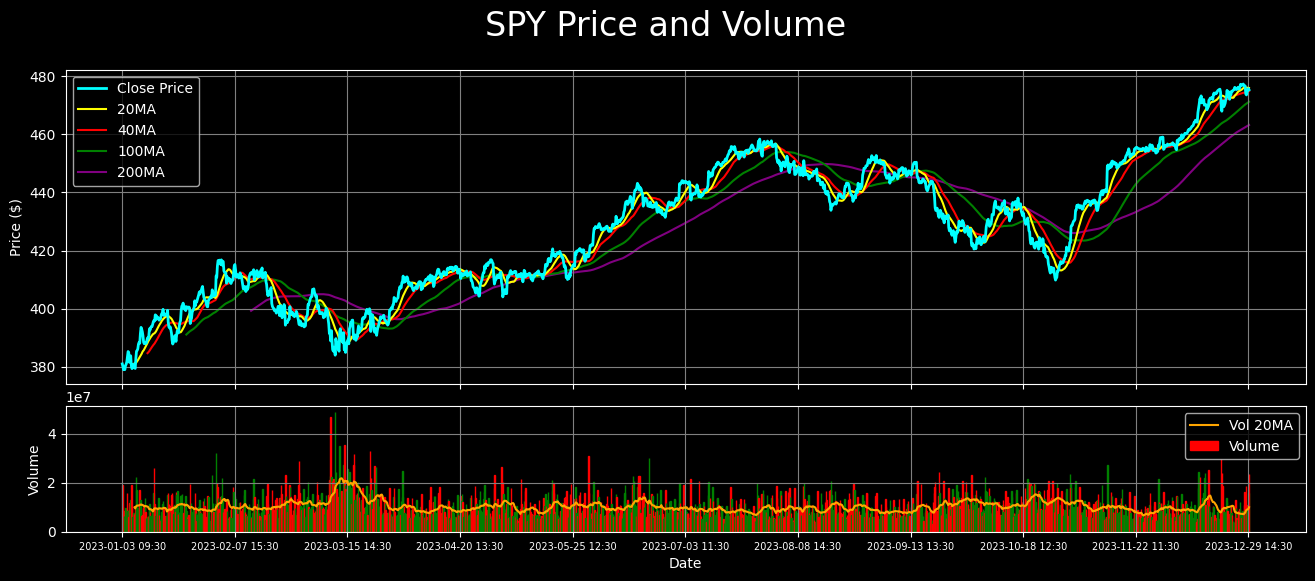

In [11]:
def plot_price_vol(
    data:       pd.DataFrame,
    ticker:     str,
    start:      str              = '1900-01-01',
    end:        str              = '2100-12-31',
    *,
    style:      str              = 'dark_background',
    figsize:    tuple[int, int]  = (16, 6),
    use_price:  str              = 'Close',
    price_clr:  str              = 'cyan',
    price_mas:  list[int] | None = [20, 40, 100, 200],
    prc_ma_clr: list[str]        = ['default'],
    volume:     bool             = True,
    bar_clr:    str              = 'default',
    volume_ma:  int | None       = 20,
    vol_ma_clr: str              = 'orange',
    legendloc:  str | None       = None
) -> None:

    """
    Plot of the price, volume and moving averages of one specified asset
    data: takes unmodified data
    """

    date_format = '%Y-%m-%d'
    if data.index.name == 'Datetime':
        date_format = '%Y-%m-%d %H:%M'
    data_to_plot = data.loc[start:end][ticker]
    data_to_plot.index = data_to_plot.index.strftime(date_format)
    data_ma = data[ticker]
    data_ma.index = data_ma.index.strftime(date_format)

    # Plot
    with plt.style.context(style):
        ratio = 0
        if volume:
            ratio = 2
        fig, axs = plt.subplots(2, figsize=(figsize), height_ratios=(5, ratio), sharex=True)
        plt.suptitle(f'{ticker} Price and Volume', size=24)
        plt.subplots_adjust(hspace=0.1)

        # Price
        axs[0].plot(data_to_plot[use_price], color=price_clr, linewidth=2, zorder=len(price_mas), label=f'{use_price} Price')

        # Moving Averages
        if price_mas != None:
            if prc_ma_clr == ['default']:
                 prc_ma_clr = ['yellow', 'red', 'green', 'purple']
            for m, c, z in zip(price_mas, range(len(prc_ma_clr)+100), range(len(price_mas)-1, -1, -1)):
                axs[0].plot(data_ma[use_price].rolling(m).mean().loc[start:end],
                            color=prc_ma_clr[c % len(prc_ma_clr)],
                            zorder=z,
                            label=f'{m}MA')

        axs[0].grid(which='major', color='grey')
        axs[0].set_ylabel('Price ($)')
        axs[0].legend(loc=legendloc)

        # Volume
        if volume:
            # Color the volume bar according to if the price went up or down during that period
            if bar_clr == 'default':
                intraday_ret = (data_ma['Close'] - data_ma['Open']) / data_ma['Open'] * 100
                bar_clr = pd.Series(['red' if ret < 0 else 'green' for ret in intraday_ret],
                                    index=intraday_ret.index
                                    ).loc[start:end]

            axs[1].bar(x=data_to_plot.index,
                       height=data_to_plot['Volume'],
                       color=bar_clr,
                       edgecolor=bar_clr,
                       label='Volume')

            # Volume Moving Average
            if volume_ma != None:
                axs[1].plot(data_ma['Volume'].rolling(volume_ma).mean().loc[start:end],
                            color=vol_ma_clr,
                            label=f'Vol {volume_ma}MA')

            axs[1].grid(which='major', color='grey')
            axs[1].set_ylabel('Volume')
            axs[1].legend(loc=legendloc)

        plt.xticks(np.arange(len(data_to_plot), step=max(len(data_to_plot) // 10, 1)), size=7)
        plt.xlabel('Date')

        plt.show()

plot_price_vol(data, 'SPY')

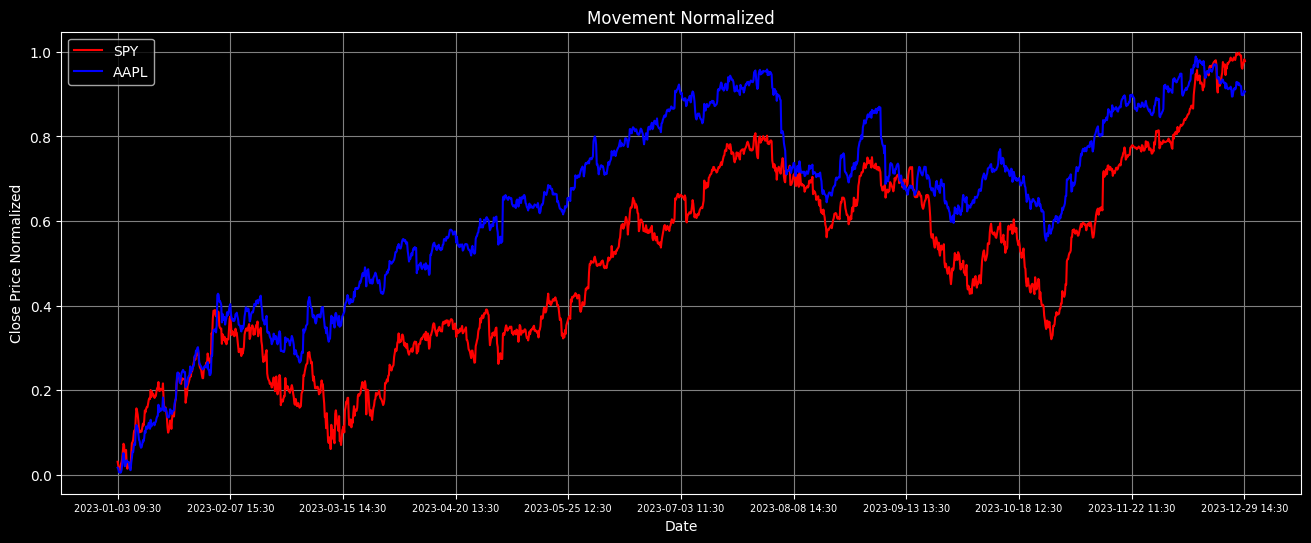

In [12]:
def plot_norm_moves(
    data_norm: pd.DataFrame,
    tickers:   list[str]  = ['show_all'],
    start:     str        = '1900-01-01',
    end:       str        = '2100-12-31',
    *,
    style:     str        = 'dark_background',
    figsize:   tuple[int] = (16, 6),
    use_price: str        = 'Close_norm',
    colors:    list[str]  = ['default'],
    legendloc: str | None = None
) -> None:

    """
    Plot the normalized price, can compare movements between assets if more than one ticker is given
    """

    # Declare variables
    if tickers == ['show_all']:
        tickers = data_norm.columns.get_level_values(0).unique()
    # Default color palette of 12 colors
    if colors == ['default']:
        colors = ['red', 'blue', 'green', 'yellow', 'magenta', 'cyan', 'purple', 'orange', 'lightblue', 'lightgreen', 'brown', 'gray']
    # Date Format
    date_format = '%Y-%m-%d'
    if data_norm.index.name == 'Datetime':
        date_format = '%Y-%m-%d %H:%M'
    data_to_plot = data_norm.loc[start:end][tickers]
    data_to_plot.index = data_to_plot.index.strftime(date_format)

    # Plot
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        plt.title('Movement Normalized')

        for i, tk in enumerate(tickers):
            plt.plot(data_to_plot[tk, use_price], color=colors[i % len(colors)], alpha=1, label=tk)

        plt.grid(which='major', color='grey')
        plt.xticks(np.arange(len(data_to_plot), step=max(len(data_to_plot) // 10, 1)), size=7)
        plt.xlabel('Date')
        plt.ylabel(f'{use_price.split("_")[0]} Price Normalized')
        plt.legend(loc=legendloc)
        plt.show()

plot_norm_moves(data_norm)

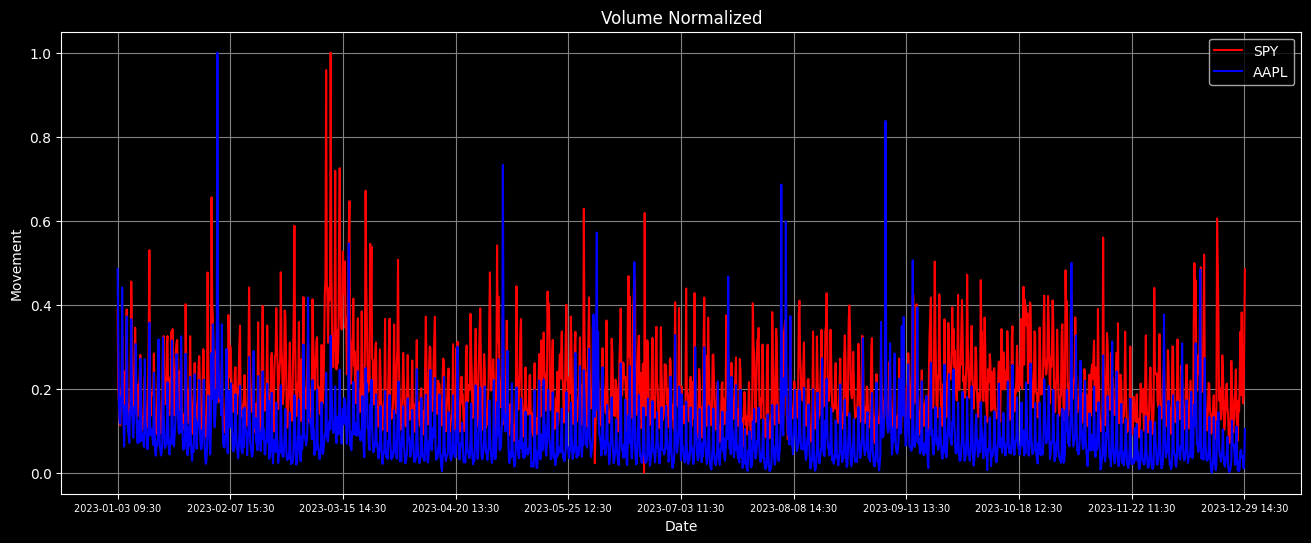

In [13]:
def plot_norm_vol(
    data_norm: pd.DataFrame,
    tickers:   list[str]  = ['first_three'],
    start:     str        = '1900-01-01',
    end:       str        = '2100-12-31',
    *,
    style:     str        = 'dark_background',
    figsize:   tuple[int] = (16, 6),
    colors:    list[str]  = ['red', 'blue', 'green'],
    legendloc: str | None = None
) -> None:

    """
    Plot movement of the volume normalized
    """

    if tickers == ['first_three']:
        tickers = returns.columns.get_level_values(0).unique()[:3]
    date_format = '%Y-%m-%d'
    if data_norm.index.name == 'Datetime':
        date_format = '%Y-%m-%d %H:%M'
    data_to_plot = data_norm.loc[start:end][tickers]
    data_to_plot.index = data_to_plot.index.strftime(date_format)

    # Plot
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        plt.title('Volume Normalized')

        for ticker, color in zip(tickers, colors):
            plt.plot(data_to_plot[ticker, 'Volume_norm'], label=ticker, color=color)

        plt.grid(which='major', color='grey')
        plt.xticks(np.arange(len(data_to_plot), step=max(len(data_to_plot) // 10, 1)), size=7)
        plt.xlabel('Date')
        plt.ylabel('Movement')
        plt.legend(loc=legendloc)
        plt.show()

plot_norm_vol(data_norm)

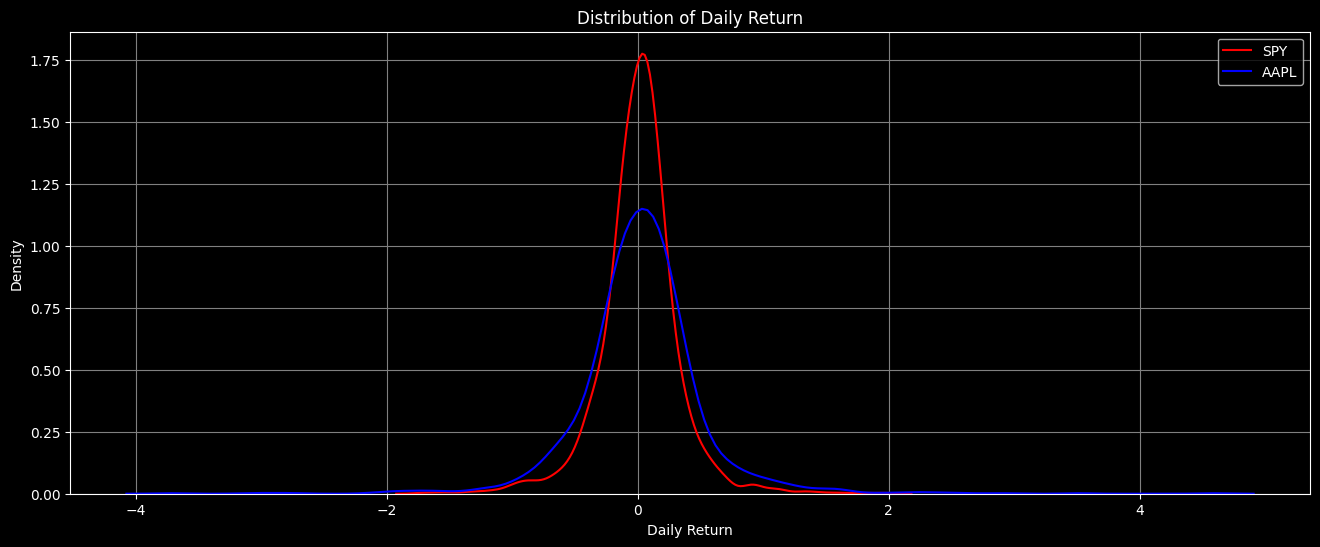

In [14]:
def plot_dist_ret(
    returns:  pd.DataFrame,
    tickers:  list[str]  = ['first_three'],
    start:    str        = '1900-01-01',
    end:      str        = '2100-12-31',
    *,
    style:    str        = 'dark_background',
    figsize:  tuple[int] = (16, 6),
    use_ret:  str        = 'Daily',
    colors:   list[str]  = ['red', 'blue', 'green'],
    hist:     bool       = True,
    kde:      bool       = True
) -> None:

    """
    Docs, max of three tickers will be shown
    """

    if tickers == ['first_three']:
        tickers = returns.columns.get_level_values(0).unique()[:3]
    else:
        tickers = tickers[:3]
    data_to_plot = returns.loc[start:end][tickers]

    with plt.style.context(style):
        plt.figure(figsize=figsize)
        plt.title(f'Distribution of {use_ret} Return')

        for ticker, color in zip(tickers, colors):
            if hist:
                sns.histplot(data_to_plot[ticker,  use_ret], bins=50, color=color, edgecolor=None, alpha=0.5, kde=False, stat="density", zorder=2, label=ticker)
            if kde:
                sns.kdeplot(data_to_plot[ticker,  use_ret], color=color, zorder=2, label=ticker)

        plt.grid(which='major', color='grey', zorder=0)
        plt.xlabel(f'{use_ret} Return')
        plt.ylabel(f'Density')
        plt.legend()

        plt.show()

plot_dist_ret(returns, hist=False)